In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def l1norm(im):
    return mean(abs(im))

def tvfunc(im):
    grad_x = concatenate((im[1:, :] - im[:-1, :], zeros((1, im.shape[1]))), axis=0)
    grad_y = concatenate((im[:, 1:] - im[:, :-1], zeros((im.shape[0], 1))), axis=1)
    return mean(sqrt(grad_x**2 + grad_y**2))

In [3]:
import glob
import os
import pydicom

In [4]:
# Point this to the location in which you have saved the LIDC-IDRI dataset
%cd ........

In [5]:
import pandas as pd

def get_metadata(file):
    with open(file, 'rb') as in_file:
        dicom = pydicom.dcmread(in_file)
    match = re.match('(.*)/(.*).dcm', file)
    folder, file_no = match.group(1), match.group(2)
    im = dicom.pixel_array.astype(np.float32)
    neg_vals = im < 0.
    if np.sum(neg_vals) > 0:
        im[im < 0.] = 0.
        circle = True
    else:
        circle = False
    im = im / 4096.
    im_max = im.max()
    l1 = l1norm(im)
    tv = tvfunc(im)
    outlier_num = tv / l1
    patient_id = int(match.group(1)) if (match := re.match('LIDC-IDRI-(\d+)', dicom[(0x10, 0x20)].repval.strip("''"))) else 0
    return pd.DataFrame({'folder': folder,
                         'file': file_no,
                         'patient id': patient_id,
                         'circle': circle,
                         'max val': im_max,
                         'rows': int(dicom.Rows),
                         'columns': int(dicom.Columns),
                         'l1': l1,
                         'tv': tv,
                         'outlier_num': outlier_num}, index=[1])

The cell below will take a while to run

In [7]:
from tqdm.notebook import tqdm
metadata = pd.concat((get_metadata(item) for item in tqdm(glob.glob('**/*.dcm'))), ignore_index=True)
metadata.to_csv('lidc-idri_metadata.csv')

In [6]:
metadata = pd.read_csv('lidc-idri_metadata.csv').drop(columns='Unnamed: 0')

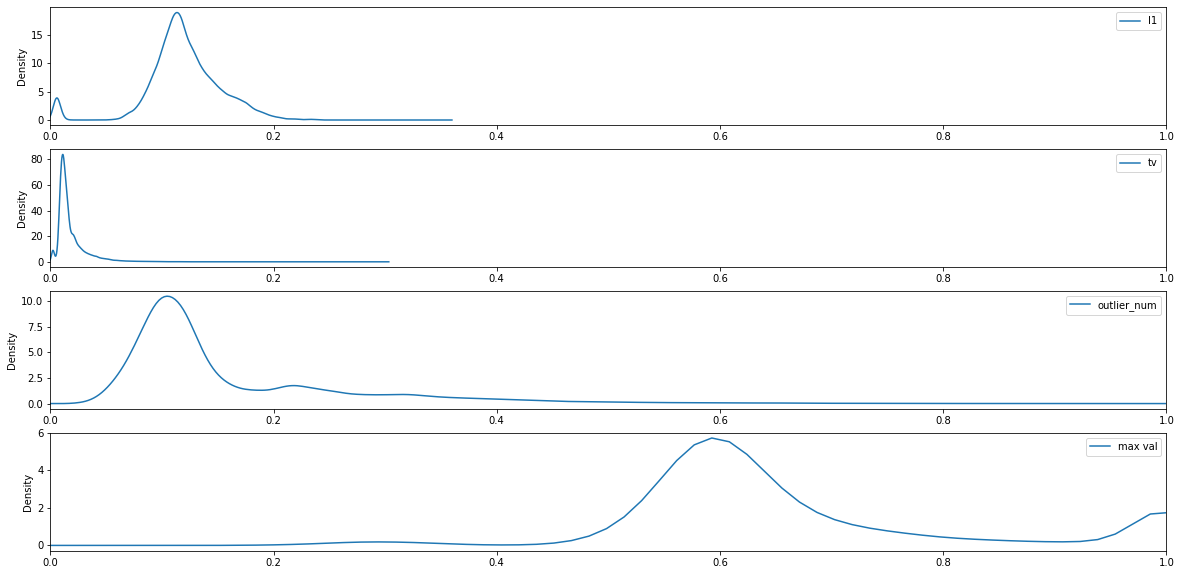

In [7]:
rcParams['figure.figsize'] = (20, 10)
stats = ['l1', 'tv', 'outlier_num', 'max val']
fig, ax = subplots(4, 1)
for i, stat in enumerate(stats):
    metadata[[stat]].plot.kde(ax=ax[i], xlim=(0, 1))

In [8]:
selection = metadata.query('`outlier_num` < 0.15 & 0.25 < `max val` < 0.75 & `tv` < 0.01')

In [9]:
selection = selection[selection['circle'] == True].reset_index().drop(columns='index')

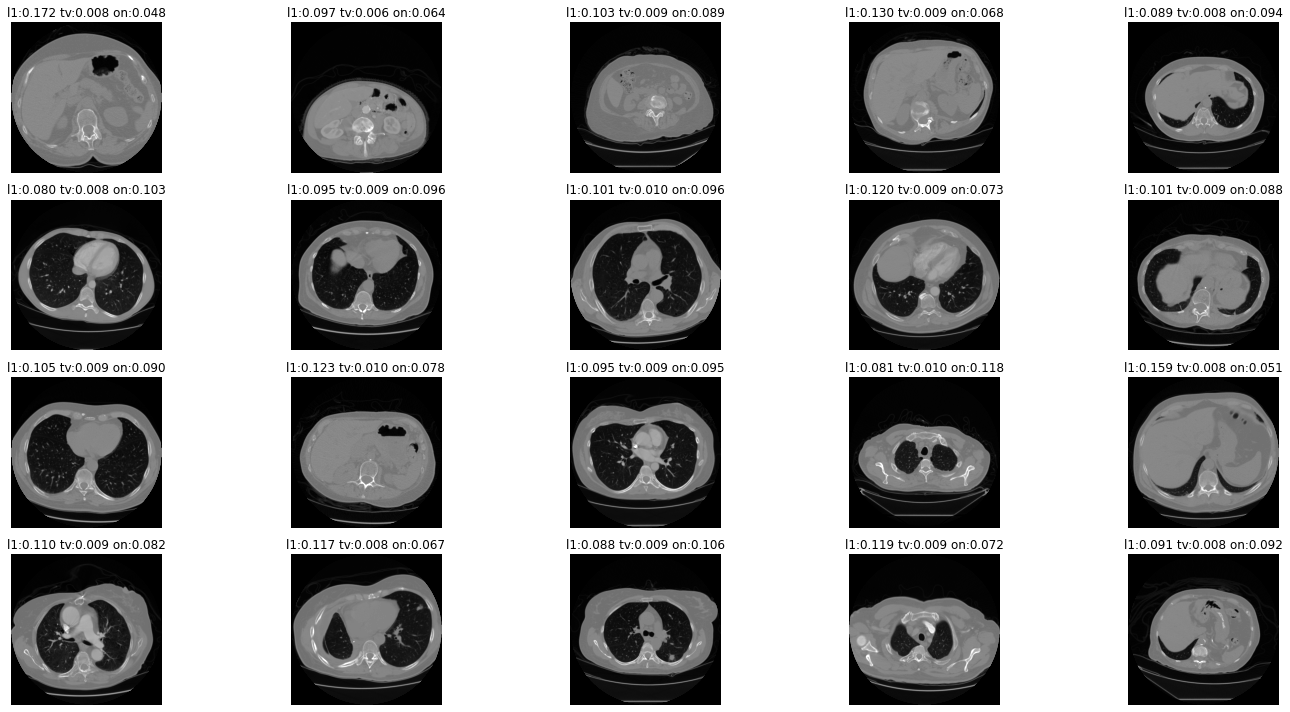

In [10]:
samp = selection.sample(20).reset_index().drop(columns='index')
for i, row in samp.iterrows():
    subplot(4, 5, i + 1)
    dcm = pydicom.dcmread(os.path.join(samp.iloc[i]['folder'], f"{samp.iloc[i]['file']}.dcm"))
    im = dcm.pixel_array
    imshow(im, cmap='gray')
    title(f"l1:{samp.iloc[i]['l1']:.3f} tv:{samp.iloc[i]['tv']:.3f} on:{samp.iloc[i]['outlier_num']:.3f}")
    clim(0, 2048)
    axis('off')
tight_layout()

In [11]:
with open('selected_ims.txt', 'w') as out_file:
    out_file.writelines(selection['folder'] + '/' + selection['file'] + '.dcm\n')

In [12]:
selection

,folder,file,patient id,circle,max val,rows,columns,l1,tv,outlier_num
0,LIDC-IDRI-0001,1-8162de90f59275a3e183cc032867dcc8,1,True,0.530029,512,512,0.094252,0.009631,0.102184
1,LIDC-IDRI-0001,7-3a13bc28f2f2fe0fc613388048258226,1,True,0.562500,512,512,0.103924,0.009137,0.087925
2,LIDC-IDRI-0001,8-436c88bae9370d8f2a66797505c61e8e,1,True,0.570312,512,512,0.110847,0.008581,0.077409
3,LIDC-IDRI-0001,9-16dbf2775ebce6f594f751432d71f26c,1,True,0.507080,512,512,0.107015,0.008880,0.082977
4,LIDC-IDRI-0001,10-850b43b5271403656b6f51bbd1287463,1,True,0.569580,512,512,0.109390,0.008368,0.076496
...,...,...,...,...,...,...,...,...,...,...
22929,LIDC-IDRI-0981,218-5fda4c0f316fff93a958fcf8bf197ff1,981,True,0.573242,512,512,0.091838,0.009719,0.105823
22930,LIDC-IDRI-0981,245-ef3d6f8e45c4838f97ce00da20e6acde,981,True,0.565674,512,512,0.090868,0.009478,0.104306
22931,LIDC-IDRI-0981,289-173690bb8e2d3d098d8de8d6581d1c02,981,True,0.537109,512,512,0.087178,0.008545,0.098016
22932,LIDC-IDRI-0981,348-5988e9df7cfed885cf76d4445b327f5a,981,True,0.552002,512,512,0.088091,0.008636,0.098033


In [346]:
from tqdm.notebook import tqdm
selected_ims = memmap('selected_ims.dat', dtype=float32, shape=(22934, 1, 512, 512), mode='w+')
for i, row in tqdm(selection.iterrows()):
    dicom = pydicom.dcmread(str(row['folder']) + '/' + row['file'] + '.dcm')
    im = dicom.pixel_array.astype(float32)
    im[im < 0.] = 0.
    im = (im + np.random.rand(*im.shape)) / 4096
    selected_ims[i, 0, ...] = im

In [15]:
from equivariant_ip.ct.forward_operators import PoissonForwardOperator, RadonForwardOperator
from equivariant_ip.utils.datasets import DatasetFromMemmap
from skimage.transform import resize
import astra
import torch
reg_vol_geom = astra.create_vol_geom(512, 512, -0.18, 0.18, -0.18, 0.18)
ups_vol_geom = astra.create_vol_geom(1024, 1024, -0.18, 0.18, -0.18, 0.18)

N_detectors = math.ceil(math.sqrt(2) * 512)
par_beam_geom = astra.create_proj_geom('parallel', math.sqrt(2) * 0.36 / N_detectors, N_detectors, linspace(0, pi, 50, endpoint=False))

sim_forward_op = PoissonForwardOperator(ups_vol_geom, par_beam_geom, N_in=10000)
recon_forward_op = RadonForwardOperator(reg_vol_geom, par_beam_geom)

In [19]:
selected_ims = memmap('selected_ims.dat', shape=(22934, 1, 512, 512), mode='r+', dtype=float32)
sinograms = memmap('measurements.dat', shape=(22934, 1, 50, 725), mode='w+', dtype=float32)

for i in tqdm(range(selected_ims.shape[0])):
    im = torch.tensor(resize(selected_ims[i, 0, ...], (1024, 1024)), device=0).view(1, 1, 1024, 1024)
    y = sim_forward_op.simulate_sinograms(im)
    sinograms[i, 0, ...] = y[0, 0, ...].cpu()

In [38]:
import pickle
with open('sparse_geometries', 'wb') as out_file:
    pickle.dump({'vol_geom': reg_vol_geom, 'ups_vol_geom': ups_vol_geom, 'proj_geom': par_beam_geom}, out_file)

In [42]:
import json
with open('sparse_params.json', 'w') as out_file:
    json.dump({'x_shape': (22934, 1, 512, 512), 'y_shape': (22934, 1, 50, 725), 'N_photons': 10000}, out_file)